# Chapter 10 - Modern Machine Learning Methods for Time Series Analysis

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error
from PythonTsa.plot_acf_pacf import acf_pacf_fig

In [4]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Time Series Predicting by Machine Learning Methods

In [6]:
url1 = ('https://raw.githubusercontent.com/QuantLet/pyTSA/refs/heads/main/pyTSA_ML/elec-temp.csv')

tsdta = pd.read_csv(url1)

tsdta

,time,load,temp
0,2012/1/1 0:00,2698.0,32.000000
1,2012/1/1 1:00,2558.0,32.666667
2,2012/1/1 2:00,2444.0,30.000000
3,2012/1/1 3:00,2402.0,31.000000
4,2012/1/1 4:00,2403.0,32.000000
...,...,...,...
26299,2014/12/31 19:00,4012.0,18.000000
26300,2014/12/31 20:00,3856.0,16.666667
26301,2014/12/31 21:00,3671.0,17.000000
26302,2014/12/31 22:00,3499.0,15.333333


In [7]:
# Convert the 'time' column to datetime format
tsdta['time'] = pd.to_datetime(tsdta['time'])  

# Set the 'time' column as the index of the dataframe
tsdta.index = tsdta['time']  

tsdta.head()

,time,load,temp
time,,,
2012-01-01 00:00:00,2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2012-01-01 02:00:00,2444.0,30.000000
2012-01-01 03:00:00,2012-01-01 03:00:00,2402.0,31.000000
2012-01-01 04:00:00,2012-01-01 04:00:00,2403.0,32.000000


In [8]:
loadts = tsdta.drop(columns = ['time', 'temp'])

loadts.head()

,load
time,
2012-01-01 00:00:00,2698.0
2012-01-01 01:00:00,2558.0
2012-01-01 02:00:00,2444.0
2012-01-01 03:00:00,2402.0
2012-01-01 04:00:00,2403.0


In [9]:
len(loadts)

26304

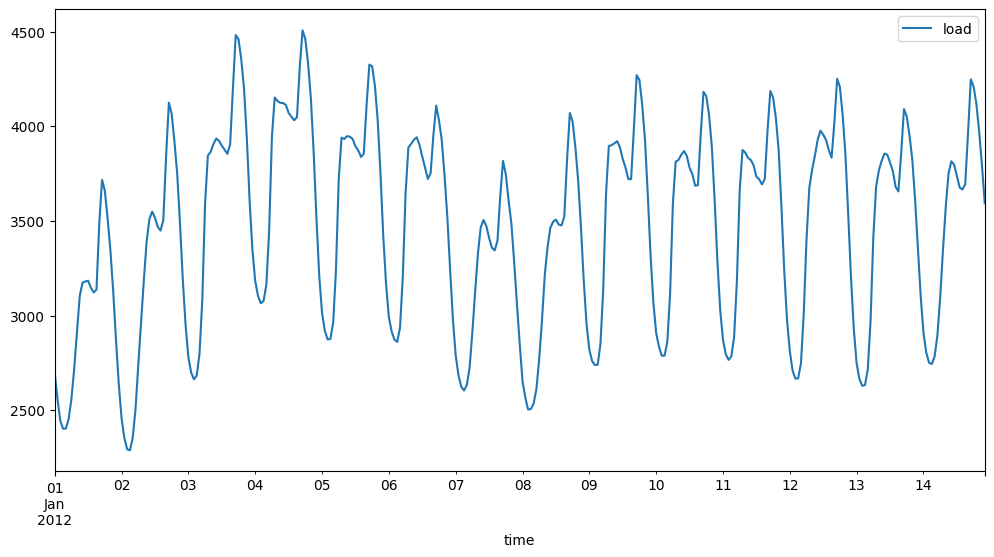

In [10]:
loadts1 = loadts[loadts.index < '2012-01-14 23:00:00']

loadts1.plot(figsize=(12, 6));

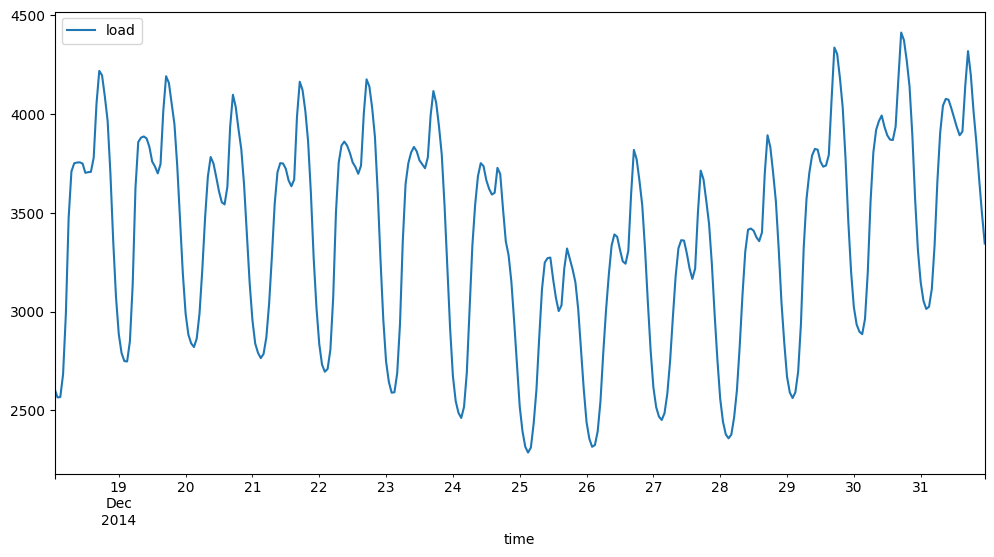

In [11]:
loadts2 = loadts[loadts.index >'2014-12-18 00:00:00']
loadts2.plot(figsize=(12, 6));

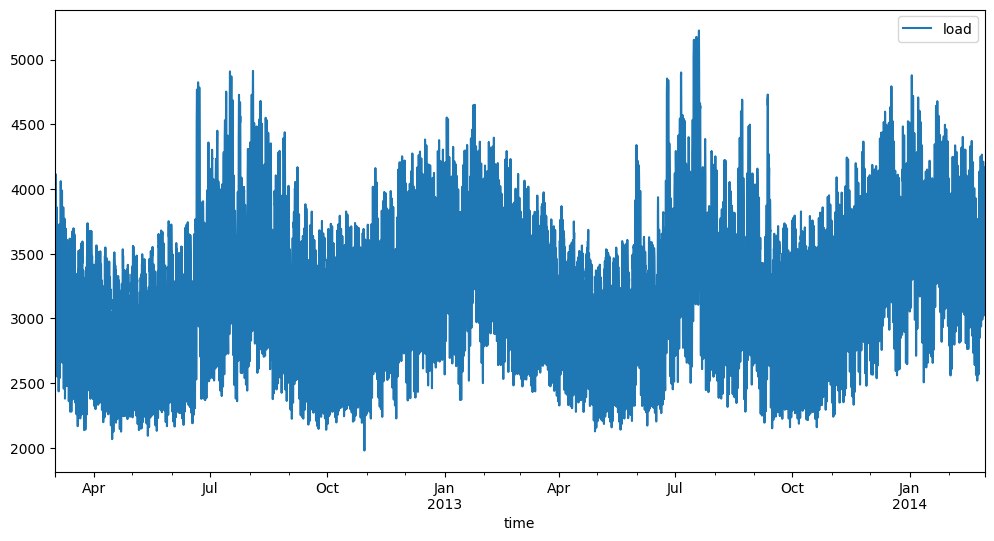

In [12]:
loadts3 = loadts[(loadts.index > '2012-03-01 00:00:00')&(loadts.index < '2014-03-01 00:00:00')]
loadts3.plot(figsize=(12, 6));

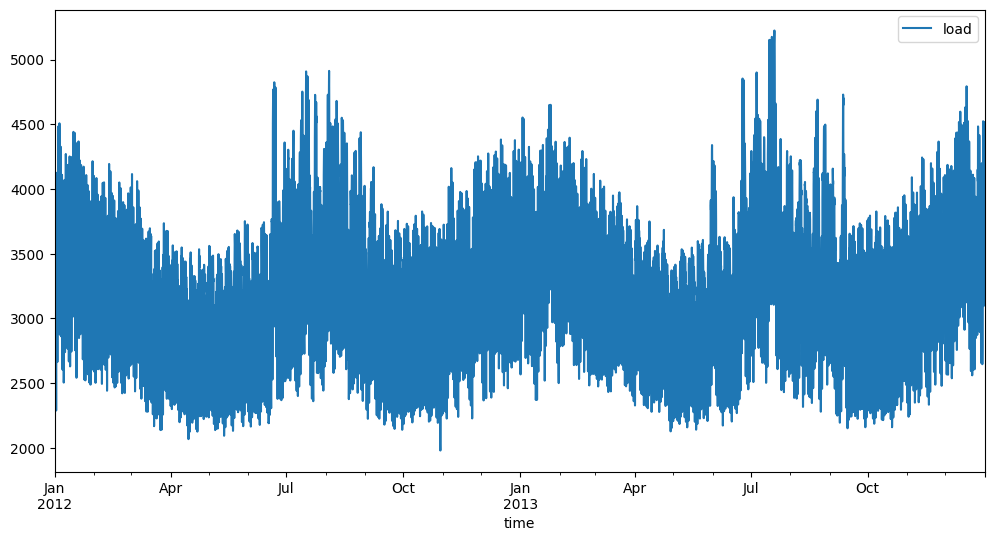

In [13]:
loadts4 = loadts[loadts.index <= '2013-12-31 23:00:00']
loadts4.plot(figsize=(12, 6));

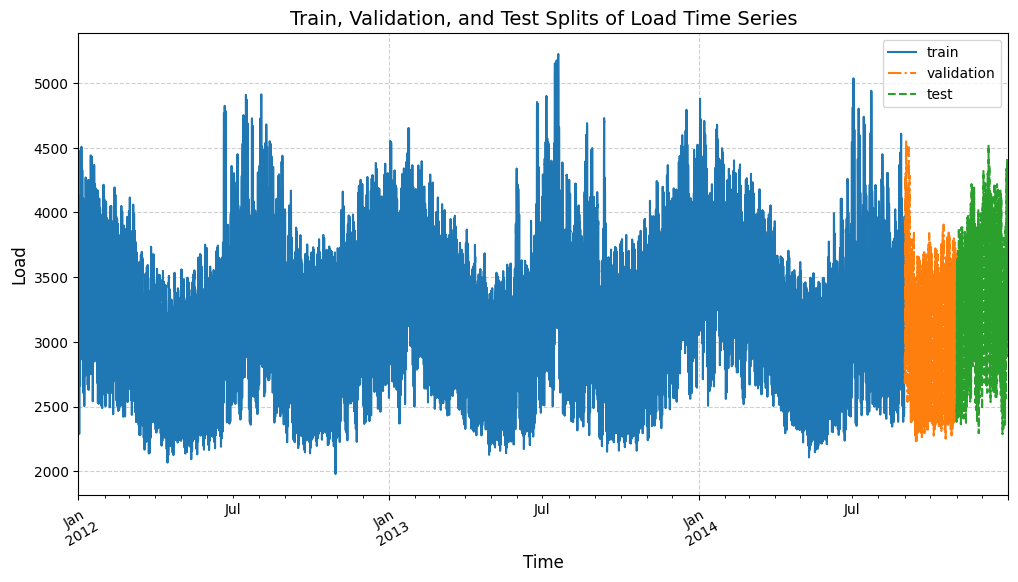

In [14]:
# Define time boundaries for training, validation, and test sets
validtime = '2014-09-01 00:00:00'   # Start of validation period
testtime = '2014-11-01 00:00:00'    # Start of test period

# Split the dataset into three segments: training, validation, and test
train_data = loadts[loadts.index < validtime].rename(columns={'load': 'train'})                                        # Data before validation period
validation_data = loadts[(loadts.index >= validtime) & (loadts.index < testtime)].rename(columns={'load': 'validation'})   # Data in validation period
test_data = loadts[testtime:].rename(columns={'load': 'test'})                                                                   # Data in test period

# Combine the datasets into a single DataFrame for plotting
combined_data = train_data.join(validation_data, how='outer').join(test_data, how='outer')


# Plot the three segments with different line styles
combined_data.plot(y=['train', 'validation', 'test'], style=['-', '-.', '--'], figsize=(12, 6))

plt.title('Train, Validation, and Test Splits of Load Time Series', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Load', fontsize=12)
plt.xticks(rotation=30)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [15]:
# Split the dataset into training, validation, and test sets based on predefined time boundaries
train = loadts.copy()[loadts.index < validtime]                                 # Training data before the validation period
valid = loadts.copy()[(loadts.index >= validtime) & (loadts.index < testtime)]  # Validation data
test = loadts.copy()[loadts.index >= testtime]                                  # Test data after the validation period

# Initialize the MinMaxScaler to normalize the data between 0 and 1
scaler = MinMaxScaler()

# Apply the scaler to each dataset separately to normalize the 'load' column
train['load'] = scaler.fit_transform(train)  # Fit and transform on training data
valid['load'] = scaler.transform(valid)      # Transform validation data using the same scaler
test['load'] = scaler.transform(test)        # Transform test data using the same scaler

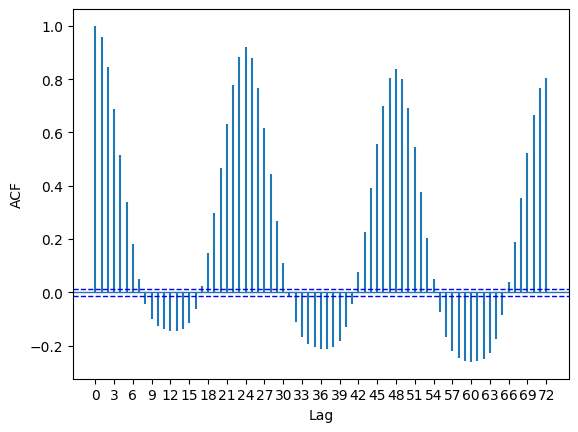

In [16]:
# Plot the ACF and PACF for the 'load' series in the training dataset
acf_pacf_fig(train.load,      # Time series data (normalized load values in training set)
             lag=72)          # Number of lags to include in the plot (up to 72)

In [17]:
# Define the input sequence length and prediction horizon
T = 24       # Use the past 24 hours of load values as input
HORIZON = 1  # One-step-ahead prediction

# Create a shifted training dataset to include past values as features
train_shifted = train.copy()

# Create the target variable (next step prediction)
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')

# Generate lagged features from the past 24 hours
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq='H')

# Define column names for the target and feature set
y_col = 'y_t+1'                               # Target variable (one-step-ahead load value)
X_cols = [f'load_t-{T-t}' for t in range(T)]  # Feature names for past load values

# Rename columns to include original load values, target, and past features
train_shifted.columns = ['load_original'] + [y_col] + X_cols

# Drop rows with NaN values resulting from shifting operations
train_shifted = train_shifted.dropna(how='any')

# Convert the target variable and feature set to NumPy arrays
y_train = np.array(train_shifted[y_col])   # Target variable as NumPy array
X_train = np.array(train_shifted[X_cols])  # Feature matrix as NumPy array

# Reshape input data to fit model requirements (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [18]:
# Create copies of the validation and test datasets for transformation
valid_shifted = valid.copy()
test_shifted = test.copy()

# Generate the target variable (next step prediction) for validation and test sets
valid_shifted['y_t+1'] = valid_shifted['load'].shift(-1, freq='H')
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')

# Generate lagged features from the past 24 hours for the validation set
for t in range(1, T+1):
    valid_shifted[str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')

# Generate lagged features from the past 24 hours for the test set
for t in range(1, T+1):
    test_shifted[str(T-t)] = test_shifted['load'].shift(T-t, freq='H')

# Rename columns for consistency
valid_shifted.columns = ['load_original'] + [y_col] + X_cols
test_shifted.columns = ['load_original'] + [y_col] + X_cols

# Drop rows with NaN values resulting from shifting operations
valid_shifted = valid_shifted.dropna(how='any')
test_shifted = test_shifted.dropna(how='any')

# Convert the target variable and feature set to NumPy arrays for validation and test sets
y_valid = np.array(valid_shifted[y_col])  # Validation target variable
y_test = np.array(test_shifted[y_col])  # Test target variable
X_valid = np.array(valid_shifted[X_cols])  # Validation feature matrix
X_test = np.array(test_shifted[X_cols])  # Test feature matrix

# Reshape input data to fit model requirements (samples, time steps, features)
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)
X_test = X_test.reshape(X_test.shape[0], T, 1)

In [19]:
# Define model hyperparameters
latent_dim = 6        # Number of units in the GRU layer (latent space dimension)
batch_size = 32       # Number of samples per batch
epochs = 15           # Number of training epochs

# Initialize the sequential model
model = Sequential()

# Add a GRU layer with 'latent_dim' units and an input shape corresponding to (T, 1)
model.add(GRU(latent_dim, input_shape=(T, 1)))  

# Add a Dense output layer with 'HORIZON' units (single-step forecast)
model.add(Dense(HORIZON))  

# Compile the model using RMSprop optimizer and Mean Squared Error (MSE) loss
model.compile(optimizer='RMSprop', loss='mse')  

# Display the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6)                 162       
                                                                 
 dense (Dense)               (None, 1)                 7         
                                                                 
Total params: 169 (676.00 Byte)
Trainable params: 169 (676.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Define an early stopping callback to prevent overfitting
GRU_earlystop = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                              min_delta=0,         # Minimum change to qualify as improvement
                              patience=5)          # Stop training after 5 epochs of no improvement

# Train the model using the training data
model_fit = model.fit(X_train,                     # Training input data
                      y_train,                     # Training target values
                      batch_size=batch_size,       # Batch size for mini-batch gradient descent
                      epochs=epochs,               # Number of training epochs
                      validation_data=(X_valid, y_valid),  # Validation data for monitoring performance
                      callbacks=[GRU_earlystop],   # Apply early stopping
                      verbose=1)                   # Display training progress

Epoch 1/15
730/730 [==============================] - 9s 9ms/step - loss: 0.0077 - val_loss: 0.0014
Epoch 2/15
730/730 [==============================] - 6s 9ms/step - loss: 0.0012 - val_loss: 8.6726e-04
Epoch 3/15
730/730 [==============================] - 9s 12ms/step - loss: 8.4557e-04 - val_loss: 0.0012
Epoch 4/15
730/730 [==============================] - 9s 13ms/step - loss: 6.9864e-04 - val_loss: 6.9647e-04
Epoch 5/15
730/730 [==============================] - 9s 13ms/step - loss: 6.2940e-04 - val_loss: 5.3807e-04
Epoch 6/15
730/730 [==============================] - 9s 13ms/step - loss: 5.9269e-04 - val_loss: 6.1737e-04
Epoch 7/15
730/730 [==============================] - 9s 13ms/step - loss: 5.8149e-04 - val_loss: 5.7292e-04
Epoch 8/15
730/730 [==============================] - 9s 12ms/step - loss: 5.7730e-04 - val_loss: 5.6892e-04
Epoch 9/15
730/730 [==============================] - 5s 6ms/step - loss: 5.7539e-04 - val_loss: 5.2401e-04
Epoch 10/15
730/730 [=================

In [21]:
# Generate predictions on the test dataset
preds = model.predict(X_test)  

# Create a DataFrame to store predictions
evdta = pd.DataFrame(preds, columns=['t+' + str(t) for t in range(1, HORIZON + 1)])  # Assign column names for horizons

# Add the time index from the test dataset
evdta['time'] = test_shifted.index  

# Reshape the DataFrame for better visualization
evdta = pd.melt(evdta, id_vars='time', value_name='fitted', var_name='h')  

# Add the actual values for comparison
evdta['actual'] = np.transpose(y_test).ravel()  

# Inverse transform to return to the original scale
evdta[['fitted', 'actual']] = scaler.inverse_transform(evdta[['fitted', 'actual']])  

# Display the first few rows of the DataFrame
evdta.head()

45/45 [==============================] - 0s 2ms/step


,time,h,fitted,actual
0,2014-11-01 23:00:00,t+1,2559.403726,2566.0
1,2014-11-02 00:00:00,t+1,2538.618499,2449.0
2,2014-11-02 01:00:00,t+1,2408.066569,2411.0
3,2014-11-02 02:00:00,t+1,2476.646412,2412.0
4,2014-11-02 03:00:00,t+1,2485.392974,2460.0


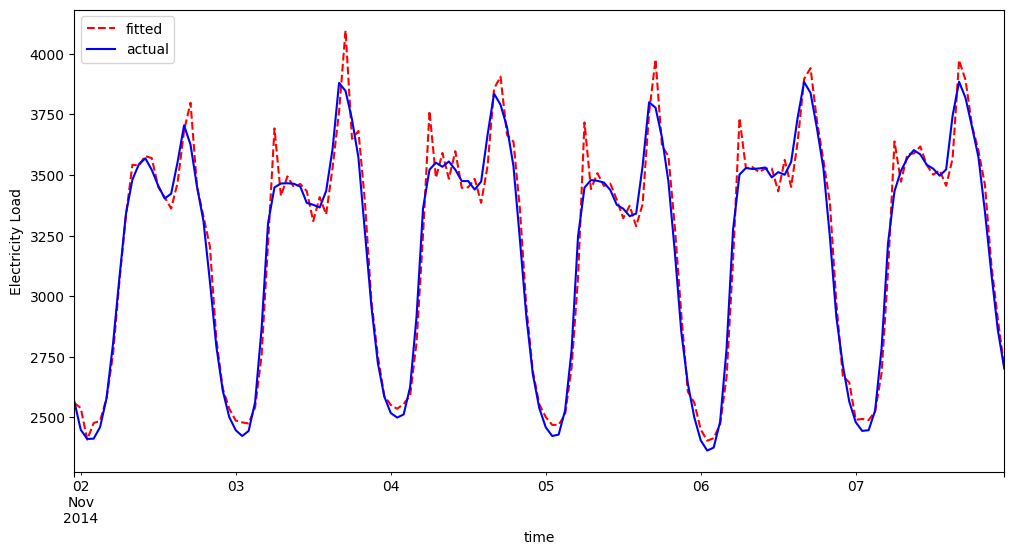

In [22]:
# Plot the actual vs. fitted values for a selected time range
evdta[evdta.time < '2014-11-08'].plot(x='time',  
                                      y=['fitted', 'actual'],  
                                      style=['--r', '-b'],     # Dashed red for fitted, solid blue for actual
                                      figsize=(12, 6))  
# Set y-axis label
plt.ylabel('Electricity Load')  

# Show the plot
plt.show()

In [23]:
# Calculate Mean Absolute Percentage Error (MAPE) between actual and fitted values
mape_value = mean_absolute_percentage_error(evdta['actual'], evdta['fitted'])

# Print MAPE value
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.4f}")

Mean Absolute Percentage Error (MAPE): 0.0161


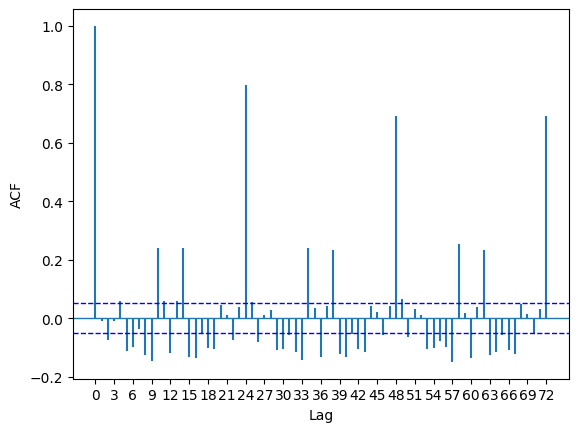

In [24]:
# Calculate residuals as the difference between actual and fitted values
resid = evdta['actual'] - evdta['fitted']  

# Plot the ACF and PACF of the residuals with a lag of 72
acf_pacf_fig(resid, lag=72)  